This ipynb needs an environment with OGGM 1.6 installed which currently does not run on Windows. See https://docs.oggm.org/en/stable/installing-oggm.html for more information on how to install OGGM.

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyproj
import salem
import xarray as xr

from pathlib import Path
from salem import GoogleVisibleMap, Map

# OGGM
import oggm_adaptions
import oggm.cfg as cfg
from oggm import utils, workflow, tasks


# Preprocessing features and targets for the PINN
This jupyter gets the processed GlaThiDa data and adds the features for the PINN using OGGM (V 1.6)

In [3]:
# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WARNING')

# Local working directory (where OGGM will write its output)
parent_path = os.path.dirname(Path().resolve())
workspace_path = os.path.join(parent_path, 'OGGM16_data_GlaThiDa_Glaciers_dhdt14') 


cfg.PARAMS['store_model_geometry'] = True


if not os.path.exists(workspace_path):
    os.mkdir(workspace_path)
    cfg.PATHS['working_dir'] = workspace_path
else:
    cfg.PATHS['working_dir'] = workspace_path

2024-03-13 15:28:51: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-03-13 15:28:51: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-03-13 15:28:51: oggm.cfg: Multiprocessing: using all available processors (N=12)
2024-03-13 15:28:52: oggm.cfg: PARAMS['grid_dx_method'] changed from `square` to `fixed`.
2024-03-13 15:28:52: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.


Get the ground truth data (gtd) and prepare it:

In [6]:
gtd_dir = '../data'
gtd_svalbard = pd.read_csv('../data/starting_datasets/svalbard_GlaThiDaTTT.csv', low_memory=False) # all measurement data from GlaThiDa pointwise dataset TTT for the region of Svalbard

print(gtd_svalbard.shape)


(964644, 19)


In [5]:
print(gtd_svalbard.RGI_ID.unique().shape)

(207,)


In [6]:
gtd_svalbard.columns

Index(['Unnamed: 0', 'GlaThiDa_ID', 'POLITICAL_UNIT', 'GLACIER_NAME',
       'SURVEY_DATE', 'PROFILE_ID', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
       'ELEVATION', 'THICKNESS', 'THICKNESS_UNCERTAINTY', 'DATA_FLAG',
       'REMARKS', 'RGI_Region', 'RGI_ID', 'RGI_subregion', 'x', 'y'],
      dtype='object')

In [7]:
# number of glaciers in the dataset
gtd_svalbard.RGI_ID.unique().shape


(207,)

In [7]:
# transform the years column to integer
gtd_svalbard['years']=gtd_svalbard['SURVEY_DATE'].astype(str).str[:4].astype(int)

<AxesSubplot:>

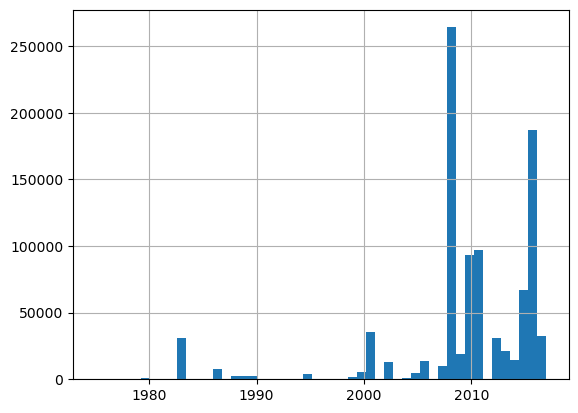

In [8]:
gtd_svalbard['years'].hist(bins=50)

In [9]:
# most recent measurement
gtd_svalbard['years'].max()

2017

In [10]:
# number of glaciers with measurements after 2000 and number of measurements
print(gtd_svalbard[gtd_svalbard.years>=2000]['RGI_ID'].unique().shape)
print(gtd_svalbard[gtd_svalbard.years>=2000].shape)


(106,)
(911044, 20)


Now we want to get rid of glaciers with active surges during the study period of 2017 and 2018 (the time of the velocity data). Study of surging glaciers in Svalbard: https://doi.org/10.3390/rs15061545
active surge phases during 2017-2018 on AUSTFONNA BASIN 3, ARNESENBREEN, STRONGBREEN,WAHLENBERGBREEN,ORSABREEN, NEGRIBREEN, TUNABREEN, PENCKBREEN, STONEBREEN, MONACOBREEN, NATHORSTBREEN (not entirely clear but I will remove it to be sure)

not found in gtd base: Ganskibreen, Markhambreen, Vasilievbreen

In [11]:
surging_glaciers = ['AUSTFONNA BASIN 3', 'ARNESENBREEN', 'STRONGBREEN','WAHLENBERGBREEN','ORSABREEN', 'NEGRIBREEN', 'TUNABREEN', 'PENCKBREEN', 'STONEBREEN', 'MONACOBREEN', 'NATHORSTBREEN']
print(len(surging_glaciers))
gtd_svalbard.GLACIER_NAME
gtd_notsurging = gtd_svalbard.apply(lambda row: row[~gtd_svalbard['GLACIER_NAME'].isin(surging_glaciers)])
gtd_notsurging.RGI_ID.unique().shape

11


(196,)

196 non-surging glaciers are left in the gtd dataframe. 
Now we want to initialize the glacier repos from OGGM. To do that we get the region file for Svalbard that has all the glaciers names and RGI IDs in it. Then we exclude the surging glaciers again by their names. 

In [12]:
# format the names of the surging glaicers to fit the format of the glacier names in the region file. 
surging_glaciers_normal = [name.capitalize() for name in surging_glaciers]
surging_glaciers_normal[0]='Austfonna Basin 3'
surging_glaciers_normal


['Austfonna Basin 3',
 'Arnesenbreen',
 'Strongbreen',
 'Wahlenbergbreen',
 'Orsabreen',
 'Negribreen',
 'Tunabreen',
 'Penckbreen',
 'Stonebreen',
 'Monacobreen',
 'Nathorstbreen']

In [13]:
# get the region file with all the RGI IDs and exclude the surging glaciers by their names
path = utils.get_rgi_region_file(region='07', version='6')
rgidf = gpd.read_file(path)
rgidf = rgidf[rgidf.O2Region=='1']
print('Number of all glaciers in Region 7.1 (Svalbard only): ', rgidf.shape[0])
rgidf = rgidf.apply(lambda row: row[~rgidf['Name'].isin(surging_glaciers_normal)])

rgilist = rgidf.RGIId.to_list() # list of all the RGI IDs of the glaciers in the region without the surging glaciers
print('Number of all glacier in Region 7.1 without the surging glaciers: ',len(rgilist))

rgi_df_grouped = gtd_notsurging.groupby('RGI_ID') # group the GlaThiDa data by RGI ID for later


(1567, 23)
1555


In [14]:
# initialize the glacier directories for the glaciers in the region without the surging glaciers
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_w_data/' # preprocessed from prepro level 3 

# either download the preprocessed data or take them from the local repository 
gdirs = workflow.init_glacier_directories(rgilist)# from local, if all the workflow steps are already done, other wise use this: 
#gdirs = workflow.init_glacier_directories(rgilist,from_prepro_level=3, prepro_base_url=base_url, prepro_border=10) # from the preprocessed directories, all of our own preprocessing steps need to be done again.

2024-03-13 15:29:02: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1555 glaciers
2024-03-13 15:29:02: oggm.workflow: WARNING: you are trying to run an entity task on 1555 glaciers with multiprocessing turned off. OGGM will run faster with multiprocessing turned on.


In [15]:
# check the first glacier directory and its file with all the gridded data
ds = oggm_adaptions.get_gridded_nc(gdirs[0])
ds

<xarray.Dataset>
Dimensions:                  (x: 68, y: 81)
Coordinates:
  * x                        (x) float32 -578.7 -557.7 -536.7 ... 807.3 828.3
  * y                        (y) float32 8.515e+06 8.515e+06 ... 8.513e+06
Data variables: (12/27)
    topo                     (y, x) float32 318.7 321.9 325.9 ... 219.2 212.6
    topo_smoothed            (y, x) float32 331.9 334.1 338.2 ... 234.8 234.0
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    ice_divides              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    slope                    (y, x) float32 0.1196 0.1624 0.2478 ... 0.1531 0.15
    aspect                   (y, x) float32 5.288 5.136 4.996 ... 2.839 2.911
    slope_factor             (y, x) float32 3.575 2.976 2.309 ... 3.083 3.121
    dis_from_border          (y, x) float32 371.5 356.4 341.9 ... 929.7 936.6
    oggm_mb_on_z             (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=17.0347 +k=0.9996 +x_0=0 +y_0...
    max_h_dem:      562.7625
    min_h_dem:      78.00895
    max_h_glacier:  426.27826
    min_h_glacier:  90.99262

In [16]:
# what are the grid resolution that OGGM provides for the glaciers?
grid_resolutions = [gdir.grid.dx for gdir in gdirs]
print(np.min(grid_resolutions), np.max(grid_resolutions), np.mean(grid_resolutions))

12.0 200.0 45.42829581993569


Now we add all the information about the glaciers that we need to the glacier directories, glacier per glacier

In [17]:
#has to be executed when the gdirs are downloaded from the base url
tasklist = [tasks.gridded_attributes, # adds things like slope, distance-to-boarder, aspect, etc.
            oggm_adaptions.hugonnet2014_to_gdir, # downloads and processes the dh/dt data from the hugonnet dataset for the time period between 2015 and 2019
            oggm_adaptions.smooth_hugonnet_dhdt2014, # smooths the dh/dt data from the hugonnet dataset
            oggm_adaptions.smooth_hugonnet_dhdt, # smooths the dh/dt data from the original hugonnet dataset that is in the preprocessed directories
            oggm_adaptions.smooth_millan, # smooths the velocity data from the millan dataset
            oggm_adaptions.gridded_oggm_mb_v16 # calculates the pointwise mass balance for the glaciers
            ]

# as this takes quite some time we check if the information is not already there
if 'dhdt2014_smoothed' not in ds:
    for task in tasklist:
        workflow.execute_entity_task(task, gdirs)
        print('executed task')

In [18]:
# now check the file with all the gridded data of the first glacier directory again
ds = oggm_adaptions.get_gridded_nc(gdirs[0])
ds

<xarray.Dataset>
Dimensions:                  (x: 68, y: 81)
Coordinates:
  * x                        (x) float32 -578.7 -557.7 -536.7 ... 807.3 828.3
  * y                        (y) float32 8.515e+06 8.515e+06 ... 8.513e+06
Data variables: (12/27)
    topo                     (y, x) float32 318.7 321.9 325.9 ... 219.2 212.6
    topo_smoothed            (y, x) float32 331.9 334.1 338.2 ... 234.8 234.0
    topo_valid_mask          (y, x) int8 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
    glacier_mask             (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    glacier_ext              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    consensus_ice_thickness  (y, x) float32 nan nan nan nan ... nan nan nan nan
    ...                       ...
    ice_divides              (y, x) int8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    slope                    (y, x) float32 0.1196 0.1624 0.2478 ... 0.1531 0.15
    aspect                   (y, x) float32 5.288 5.136 4.996 ... 2.839 2.911
    slope_factor             (y, x) float32 3.575 2.976 2.309 ... 3.083 3.121
    dis_from_border          (y, x) float32 371.5 356.4 341.9 ... 929.7 936.6
    oggm_mb_on_z             (y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    author:         OGGM
    author_info:    Open Global Glacier Model
    pyproj_srs:     +proj=tmerc +lat_0=0 +lon_0=17.0347 +k=0.9996 +x_0=0 +y_0...
    max_h_dem:      562.7625
    min_h_dem:      78.00895
    max_h_glacier:  426.27826
    min_h_glacier:  90.99262

Plot the mass balance, dhdt and resulting apparent mass balance. Compare the original to the smoothed velocity. 

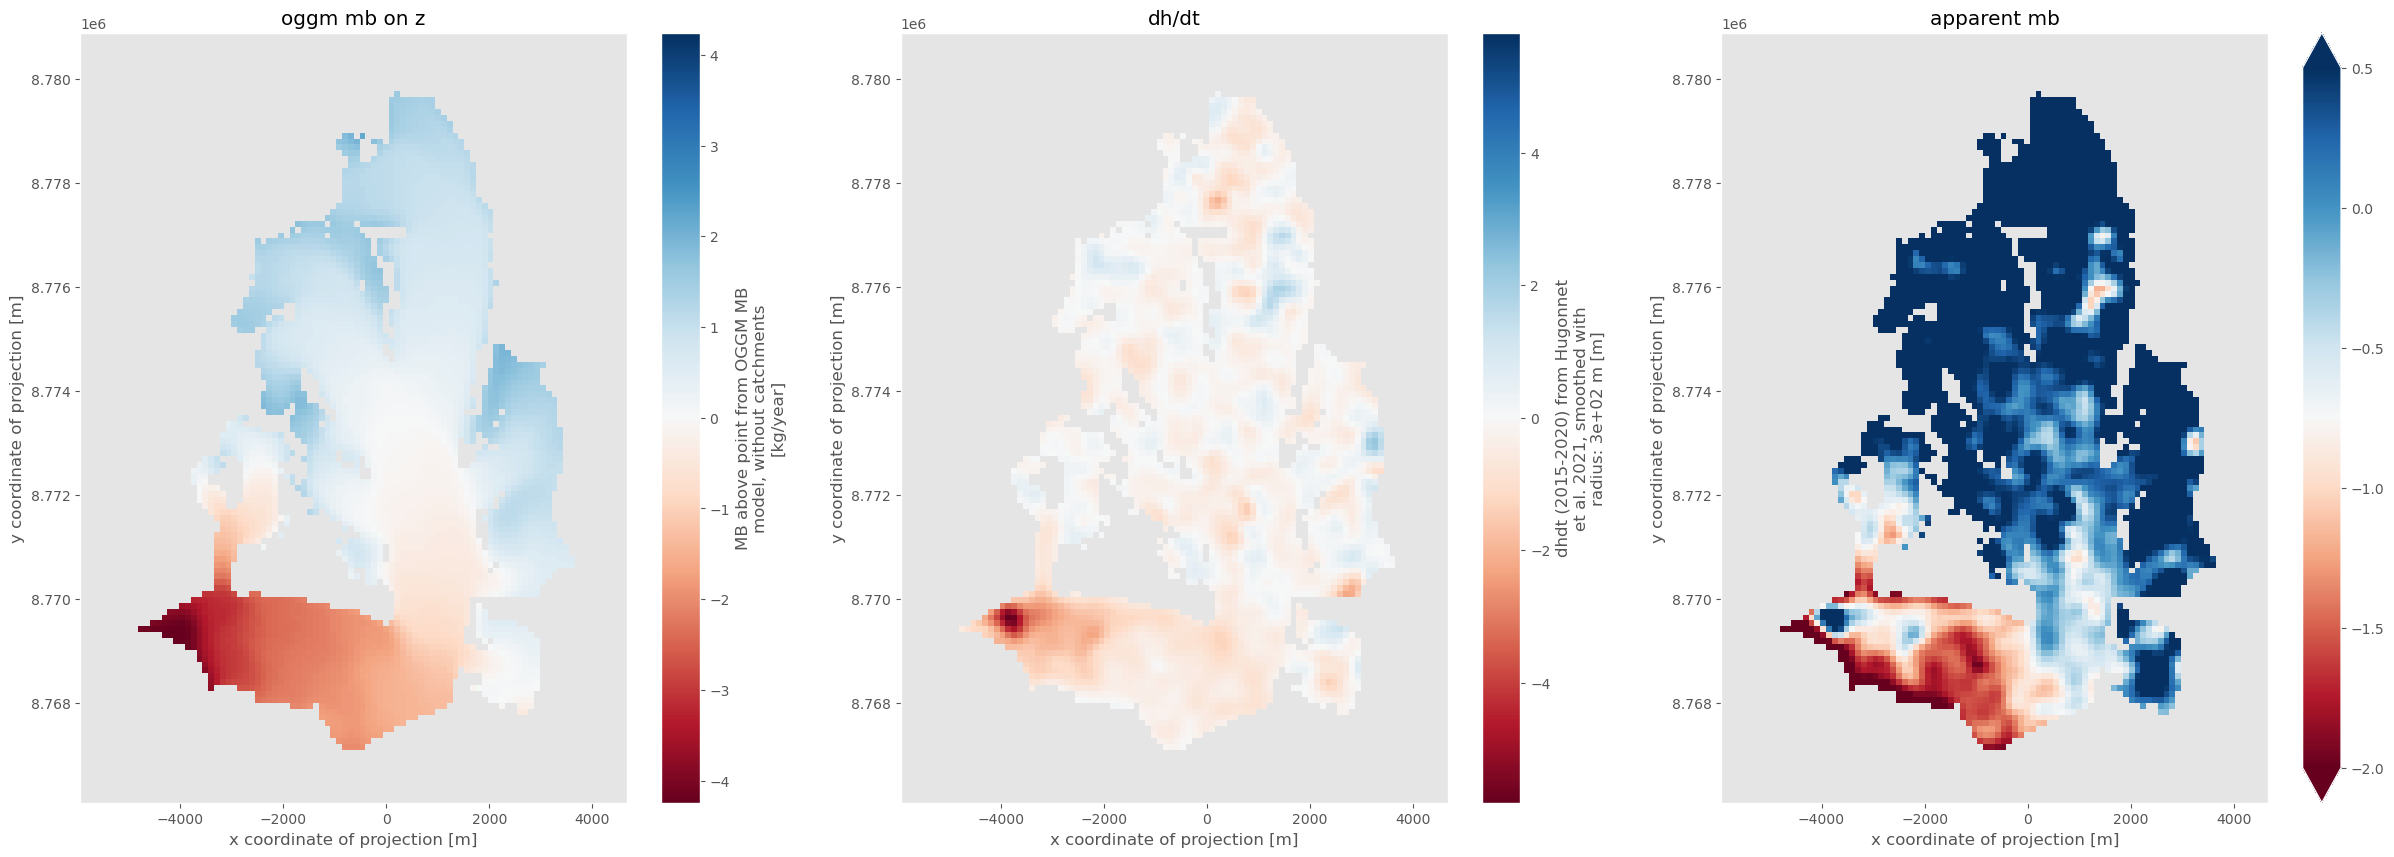

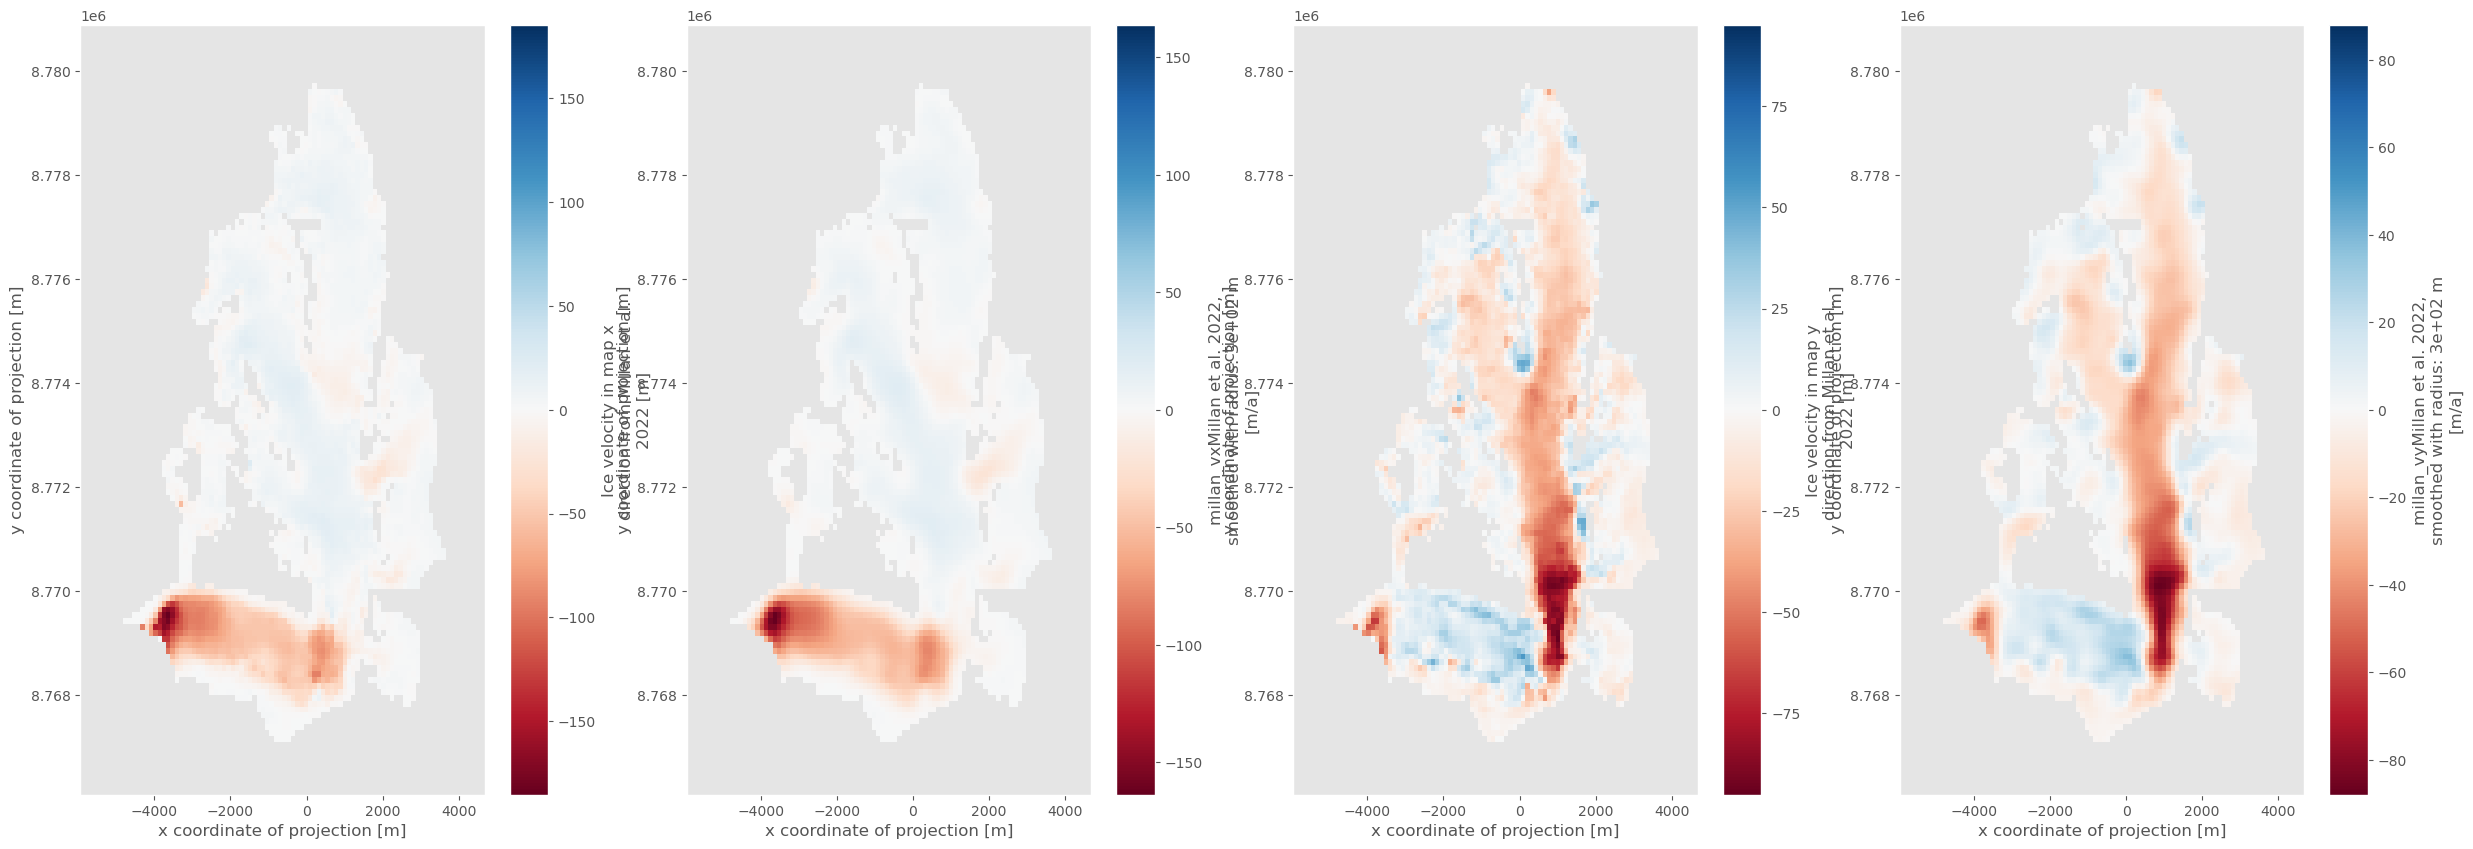

In [181]:
i, gdir = oggm_adaptions.search_RGI_ID_in_gdirs('RGI60-07.00524', gdirs)
ds = oggm_adaptions.get_gridded_nc(gdir)

f, (ax1, ax3, ax4) = plt.subplots(1, 3, figsize=(30,10))
ds.oggm_mb_on_z.where(ds.glacier_mask==1).plot(ax=ax1, cmap='RdBu')
ax1.set_title('oggm mb')
ds.dhdt2014_smoothed.where(ds.glacier_mask==1).plot(ax=ax3, cmap='RdBu')
ax3.set_title('dh/dt')
(ds.oggm_mb_on_z-ds.dhdt2014_smoothed).plot(ax=ax4,vmax=0.5, vmin=-2, cmap='RdBu')
ax4.set_title('apparent mb')
plt.show()

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30,10))
ds.millan_vx.where(ds.glacier_mask==1).plot(ax=ax1, cmap='RdBu' )
ds.millan_vx_smoothed.where(ds.glacier_mask==1).plot(ax=ax2, cmap='RdBu')
ds.millan_vy.where(ds.glacier_mask==1).plot(ax=ax3,cmap='RdBu')
ds.millan_vy_smoothed.where(ds.glacier_mask==1).plot(ax=ax4,cmap='RdBu')
plt.show()

In [26]:
gtd_notsurging.columns

Index(['Unnamed: 0', 'GlaThiDa_ID', 'POLITICAL_UNIT', 'GLACIER_NAME',
       'SURVEY_DATE', 'PROFILE_ID', 'POINT_ID', 'POINT_LAT', 'POINT_LON',
       'ELEVATION', 'THICKNESS', 'THICKNESS_UNCERTAINTY', 'DATA_FLAG',
       'REMARKS', 'RGI_Region', 'RGI_ID', 'RGI_subregion', 'x', 'y', 'years'],
      dtype='object')

Now that all the information is there, we make dataframes from the xarrays. One dataframe holds all the points with ground truth ice thicknesses aggregated at the nearest OGGM glacier grid point.
The other dataframe has all the points of the OGGM glacier grids for the glaciers with measurements.

In [21]:

df_agg_measurements = pd.DataFrame() # Aggregated measurements
df_glacier_grids = pd.DataFrame() # Only gridded data without measurements

# list of variables that we want to have in our datasets
vns=[   'topo',
        'slope',
        'slope_factor',
        'aspect',
        'dis_from_border', 
        'oggm_mb_on_z',
        'hugonnet_dhdt2014',
        'dhdt2014_smoothed',
        'millan_v_smoothed',
        'millan_vx_smoothed',
        'millan_vy_smoothed',
        'millan_ice_thickness', 
        'consensus_ice_thickness'
        ]


for gdir in gdirs:       
        try:
                glacier_df = rgi_df_grouped.get_group(gdir.rgi_id)
                print(gdir.rgi_id)
        except KeyError:
                print('no measurements for this glacier: ', gdir.rgi_id)
                continue
        df_agg = glacier_df[['POINT_LON', 'POINT_LAT', 'THICKNESS', 'THICKNESS_UNCERTAINTY','years']].copy()
        # Aggregate the measurements to the grid
        ii, jj = gdir.grid.transform(glacier_df['POINT_LON'], glacier_df['POINT_LAT'], crs=salem.wgs84, nearest=True) # transform the coords of the measurements to the grid crs of the glacier
        # Aggregation strategy from OGGM tutorial: https://oggm.org/tutorials/stable/notebooks/10minutes/machine_learning.html
        df_agg['i'] = ii
        df_agg['j'] = jj
        # We trick by creating an index of similar i's and j's
        df_agg['ij'] = ['{:04d}_{:04d}'.format(int(i), int(j)) for i, j in zip(ii, jj)]
        df_agg = df_agg.groupby('ij').mean() # mean lon/lat, thickness, thickness_uncertainty and year for each point 
        # Conversion does not preserve ints
        df_agg['i'] = df_agg['i'].astype(int)
        df_agg['j'] = df_agg['j'].astype(int)

        # now add all the gridded data
        with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
                ds = ds.load()

        # Add the variables to the dataframe
        for vn in vns:
                df_agg[vn] = ds[vn].isel(x=('z', df_agg['i']), y=('z', df_agg['j'])) # dataframe with variables vn aggregated at points where aggregated measurements from glathida would be

        #transform the averaged lon lat coord of measurements to the grid of glacier in case we want to use the glaciers grid for better plotting or so
        x, y = salem.transform_proj(salem.wgs84, gdir.grid.proj, df_agg.POINT_LON.values, df_agg.POINT_LAT.values) 
        df_agg['x'], df_agg['y'] = [x, y] 
        
        df_agg['RGI_ID']=gdir.rgi_id
        df_agg['area']=gdir.rgi_area_m2
        df_agg['type']=gdir.glacier_type # glacier type is a bit weirdly defined in the OGGM 
        df_agg['terminus_type']=gdir.terminus_type # terminus type might also be a bit weirdly defined in the OGGM

        df_agg_measurements = pd.concat([df_agg_measurements, df_agg]) # dataframe with variables vn aggregated at points near measurements concatenated for every glacier that we have measurements from glathida
        
        #### collect gridded data without measurements for every glacier

        dsdf = ds.to_dataframe() # turn the nc file into a dataframe with all information of the grid over the glacier

        dsdf.reset_index(inplace=True)
        dsdf= dsdf[dsdf.glacier_mask==1] # only take values within the glacier outline, at other points thickness is not defined and would make the dataset incredibly huge
        dsdf['RGI_ID']=gdir.rgi_id 
        dsdf['area']=gdir.rgi_area_m2
        dsdf['type']=gdir.glacier_type
        dsdf['terminus_type']=gdir.terminus_type

        lon, lat = salem.transform_proj(gdir.grid.proj, salem.wgs84, dsdf.x.values, dsdf.y.values) #transform the glacier grid projection back to lon lat values in wgs84, to match with the measurements
        dsdf['POINT_LON'], dsdf['POINT_LAT'] = [lon, lat] 

        df_glacier_grids = pd.concat([df_glacier_grids, dsdf]) # concatenate with other glacier dataframes


RGI60-07.00001
no measurements for this glacier
RGI60-07.00002
no measurements for this glacier
RGI60-07.00003
no measurements for this glacier
RGI60-07.00004
no measurements for this glacier
RGI60-07.00005
no measurements for this glacier
RGI60-07.00006
no measurements for this glacier
RGI60-07.00007
no measurements for this glacier
RGI60-07.00008
no measurements for this glacier
RGI60-07.00009
no measurements for this glacier
RGI60-07.00010
no measurements for this glacier
RGI60-07.00011
no measurements for this glacier
RGI60-07.00012
no measurements for this glacier
RGI60-07.00013
no measurements for this glacier
RGI60-07.00014
no measurements for this glacier
RGI60-07.00015
no measurements for this glacier
RGI60-07.00016
no measurements for this glacier
RGI60-07.00017
no measurements for this glacier
RGI60-07.00018
no measurements for this glacier
RGI60-07.00019
no measurements for this glacier
RGI60-07.00020
no measurements for this glacier
RGI60-07.00021
no measurements for this 

Collect all the points of the OGGM glacier grids for the glaciers (with and without measurements).

In [22]:
       
#### collect gridded data without measurements for every glacier
df_glacier_grids_allglaciers = pd.DataFrame()
for gdir in gdirs:
      
        with xr.open_dataset(gdir.get_filepath('gridded_data')) as ds:
                ds = ds.load()
        
        dsdf = ds.to_dataframe() # turn the nc file into a dataframe with all information of the grid over the glacier

        dsdf.reset_index(inplace=True)
        dsdf= dsdf[dsdf.glacier_mask==1] # only take values within the glacier outline, at other points thickness is not defined
        dsdf['RGI_ID']=gdir.rgi_id
        dsdf['area']=gdir.rgi_area_m2
        dsdf['type']=gdir.glacier_type

        lon, lat = salem.transform_proj(gdir.grid.proj, salem.wgs84, dsdf.x.values, dsdf.y.values) #transform the glacier grid projection back to lon lat values in wgs84, to match with the measurements --> will be transformed to epsg3049 in dataloader
        dsdf['POINT_LON'], dsdf['POINT_LAT'] = [lon, lat] 
        # lon1, lat1 = salem.transform_proj(gdir.grid.proj, crs_epsg3049, dsdf.x.values, dsdf.y.values) #transform the glacier grid projection back to lon lat values
        # dsdf['POINT_LON3049'], dsdf['POINT_LAT3049'] = [lon1, lat1]
        df_glacier_grids_allglaciers = pd.concat([df_glacier_grids_allglaciers, dsdf]) # concatenate with other glacier dataframes

Add the apparent mass balance to the three dataframes: 

In [23]:
df_agg_measurements['apparent_mb2014']= df_agg_measurements['oggm_mb_on_z']-df_agg_measurements['dhdt2014_smoothed']
df_glacier_grids['apparent_mb2014']= df_glacier_grids['oggm_mb_on_z']-df_glacier_grids['dhdt2014_smoothed']
df_glacier_grids_allglaciers['apparent_mb2014']= df_glacier_grids_allglaciers['oggm_mb_on_z']-df_glacier_grids_allglaciers['dhdt2014_smoothed']


Cleaning the dataframes: without thickness there should not be movement

In [25]:
print(df_agg_measurements[~(df_agg_measurements.THICKNESS!=0|((df_agg_measurements.millan_v_smoothed==0)))].shape) #double check 
print(df_agg_measurements.shape)

df_agg_measurements = df_agg_measurements[(df_agg_measurements.THICKNESS!=0|((df_agg_measurements.millan_vx_smoothed==0) & (df_agg_measurements.millan_vy_smoothed==0)))]
df_agg_measurements.shape

(294, 27)
(54370, 27)


In [26]:

df_agg_measurements = df_agg_measurements[(df_agg_measurements.THICKNESS!=0|((df_agg_measurements.millan_vx_smoothed==0) & (df_agg_measurements.millan_vy_smoothed==0)))]
df_agg_measurements.shape

(294, 27)


(54076, 27)

## basal sliding correction 
Surface velocity $v_s$ has a ice deformation and basal sliding component: $v_s = v_{basal}+v_{def}$ <br>
Millan et al. correct for basal sliding by introducing the ratio of slope/$v_s$ that then translates to a parameter $\beta$ such that $v_{basal}=\beta*v_s$ <br>
and therefore $v_{def}= v_s-v_{basal}=v_s(1-\beta)$

0.9573167141401899


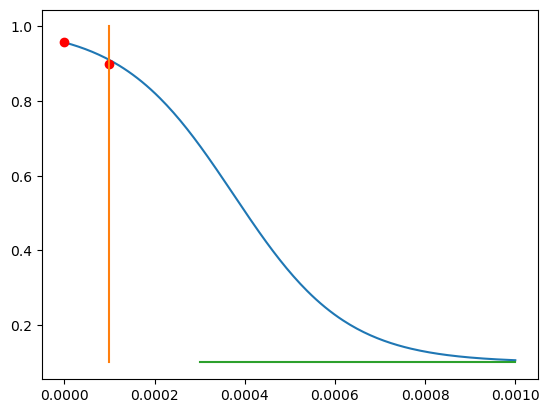

In [27]:
x=np.linspace(0.000001,0.001,200)
y = np.tanh(-4000*x+1.5)*0.45+0.55
plt.plot(x,y)
plt.plot(0.0001, 0.9, 'ro')
plt.plot(0.0000, np.tanh(-4000*0+1.5)*0.45+0.55, 'ro')
plt.plot([0.0001, 0.0001], [0.1, 1.0])
plt.plot([0.0003, 0.001], [0.1, 0.1])
print(np.tanh(-4000*0+1.5)*0.45+0.55)

In [28]:
def beta_calc(df):
    slope_vel_ratio = df['slope']/df['millan_v_smoothed']
    slope_vel_ratio_x = df['slope']/df['millan_vx_smoothed'].abs()
    slope_vel_ratio_y = df['slope']/df['millan_vy_smoothed'].abs()
    # beta values should range from 0.1 for no basal sliding to 0.9 for basal sliding, the values in the formula are experimentally derived from adjusting the function to fit this boundaries
    beta_v = [np.tanh(-4000*x+1.5)*0.45+0.55 for x in slope_vel_ratio] #the old funciton was np.tanh(-6000*x+4)*0.4+0.5 but this is not fitting the different glaciers well
    beta_vx = [np.tanh(-4000*x+1.5)*0.45+0.55 for x in slope_vel_ratio_x]
    beta_vy = [np.tanh(-4000*x+1.5)*0.45+0.55 for x in slope_vel_ratio_y]
    df['beta_v']=beta_v
    df['beta_vx']=beta_vx
    df['beta_vy']=beta_vy
    
    
beta_calc(df_agg_measurements)
beta_calc(df_glacier_grids)
beta_calc(df_glacier_grids_allglaciers) #calcluate betas for all unmapped glaciers
df_glacier_grids.beta_vy


2694    0.1
2695    0.1
2696    0.1
2697    0.1
2698    0.1
       ... 
9221    0.1
9222    0.1
9320    0.1
9321    0.1
9322    0.1
Name: beta_vy, Length: 936353, dtype: float64

Look at different types of glaciers as defined by OGGM 

189
118
71


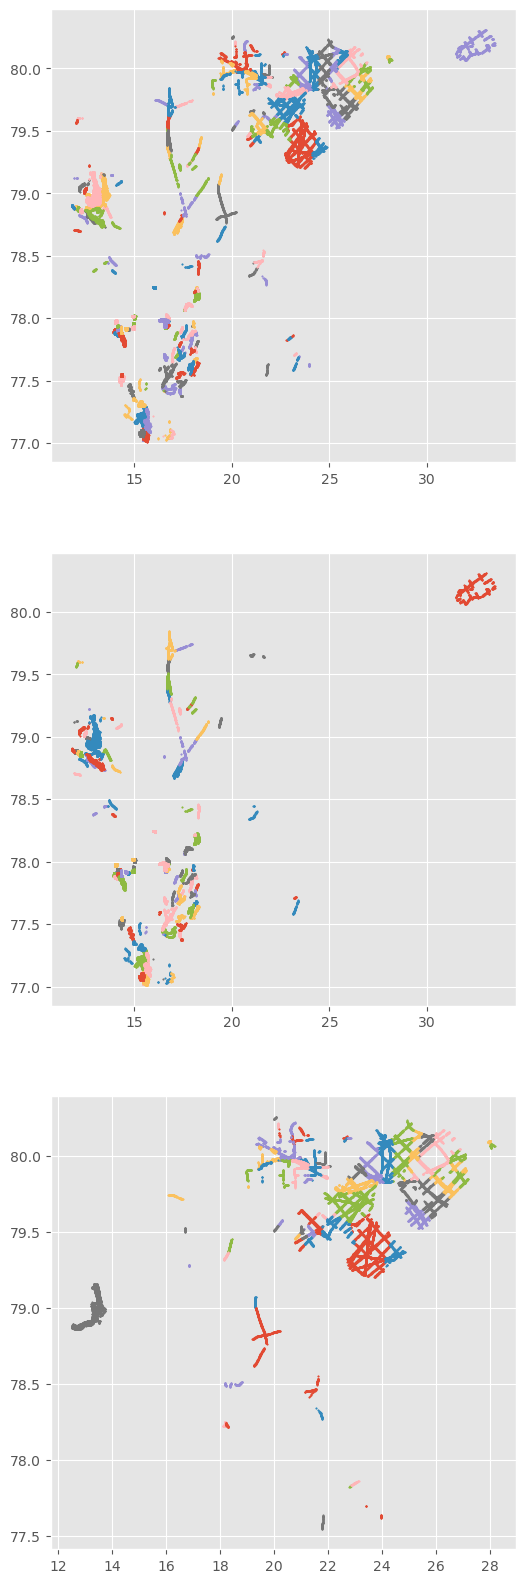

In [189]:
glacier_groups = df_agg_measurements.groupby('RGI_ID')
f, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(6,20))
for i, g in glacier_groups:
    ax1.scatter(g.POINT_LON, g.POINT_LAT, s=1)

print(len(glacier_groups))
glacier_groups = df_agg_measurements[df_agg_measurements['type']=='Glacier'].groupby('RGI_ID')
for i, g in glacier_groups:
    ax2.scatter(g.POINT_LON, g.POINT_LAT, s=1)
print(len(glacier_groups))
glacier_groups = df_agg_measurements[df_agg_measurements['type']=='Ice cap'].groupby('RGI_ID')
for i, g in glacier_groups:
    ax3.scatter(g.POINT_LON, g.POINT_LAT, s=1)
print(len(glacier_groups))

# Making different datasets

In [191]:
# get dataframe for a single glacier
df_singleglacier_grid = df_glacier_grids[df_glacier_grids.RGI_ID=='RGI60-07.01482']
df_singleglacier_measurement = df_agg_measurements[df_agg_measurements.RGI_ID=='RGI60-07.01482']

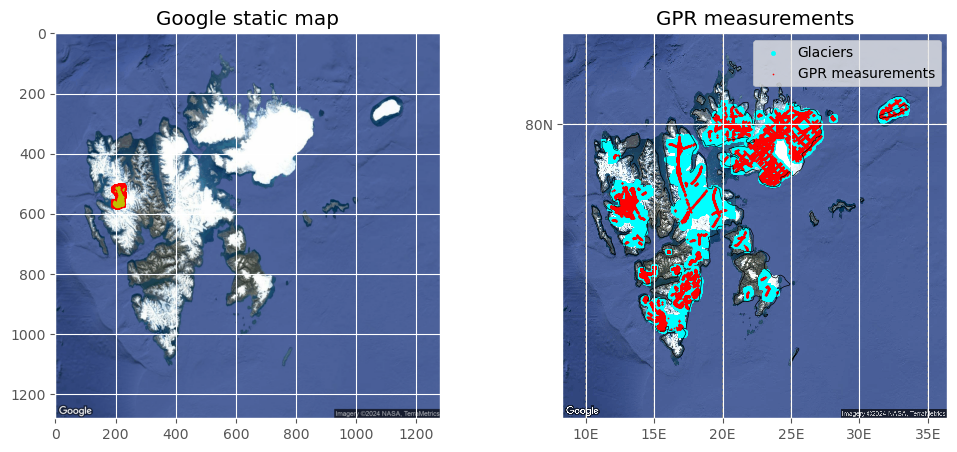

In [193]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))#
crs_lonlat = pyproj.crs.CRS.from_epsg(4326)

g = GoogleVisibleMap(x=[df_glacier_grids.POINT_LON.min(),df_glacier_grids.POINT_LON.max()], y=[df_glacier_grids.POINT_LAT.min(), df_glacier_grids.POINT_LAT.max()],
                     scale=2,  # scale is for more details
                     maptype='satellite', crs=crs_lonlat)
ggl_img = g.get_vardata()

sm = Map(g.grid, factor=1, countries=True)
sm.set_rgb(ggl_img)  # add the background rgb image

x, y = sm.grid.transform(df_singleglacier_grid.POINT_LON.values, df_singleglacier_grid.POINT_LAT.values,crs=crs_lonlat)
ax1.scatter(x, y, marker='.', c='r')
x, y = sm.grid.transform(df_singleglacier_measurement.POINT_LON.values, df_singleglacier_measurement.POINT_LAT.values,crs=crs_lonlat)
ax1.scatter(x, y, marker='.', c='y', s=1)

ax1.imshow(ggl_img)
ax1.set_title('Google static map')

# sm = Map(g.grid, factor=1, countries=True)
# #sm.set_shapefile(shp)  # add the glacier outlines
# sm.set_rgb(ggl_img)  # add the background rgb image
#sm.set_scale_bar(location=(0.88, 0.94))  # add scale
sm.visualize(ax=ax2)  # plot it
ax2.set_title('GPR measurements')
x, y = sm.grid.transform(df_glacier_grids.POINT_LON.values, df_glacier_grids.POINT_LAT.values,crs=crs_lonlat)
ax2.scatter(x, y, marker='.', c='cyan', label='Glaciers')#, c=itslive.dataset.labeled_dataset.consensus_ice_thickness, s=10,  linewidths=1)
x, y = sm.grid.transform(df_agg_measurements.POINT_LON.values, df_agg_measurements.POINT_LAT.values,crs=crs_lonlat)
ax2.scatter(x, y,marker='.', c='r', s=2, label='GPR measurements')
plt.legend()

From throwing out datapoints that were invalid we might have lost entire glaciers, so check for glaciers that are in the grid dataset but not in the measurements dataset

In [30]:
df_agg_measurements.groupby('RGI_ID')
print(df_agg_measurements.RGI_ID.unique().shape)
print(df_glacier_grids.RGI_ID.unique().shape)
# get only glaciers that have measurements
df_glacier_grids=df_glacier_grids[df_glacier_grids.RGI_ID.isin(df_agg_measurements.RGI_ID.unique())]

(189,)
(196,)


# Get datasets without Austfonna and Vestfonna and Kvitoya

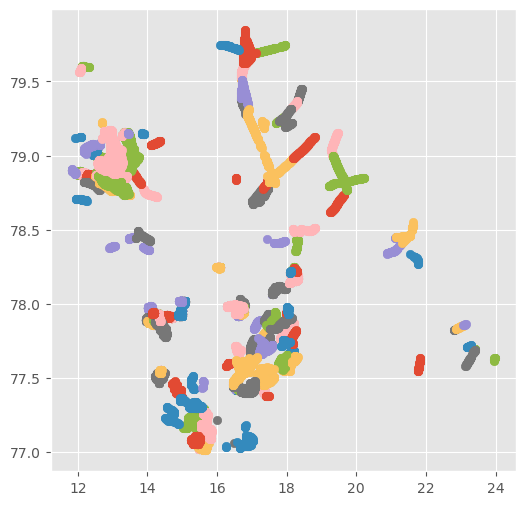

In [32]:
plt.style.use('ggplot')
glacier_groups = df_agg_measurements.groupby('RGI_ID')
spitsbergen_measurements = pd.DataFrame()
f, ax2= plt.subplots(1,1, figsize=(6,6))

for i, rgi in glacier_groups:
    if rgi.POINT_LON.max()<19 or rgi.POINT_LAT.max()<79.3:
        # print(rgi.RGI_ID.unique(), rgi.type.unique())
        ax2.scatter(rgi.POINT_LON, rgi.POINT_LAT,  label=i)
        rgi['RGI_ID']=i
        spitsbergen_measurements=pd.concat([spitsbergen_measurements, rgi])
print(spitsbergen_measurements.head())

# now get the glacier grids of the glaciers with measurements
df_spitsbergen_grids=df_glacier_grids[df_glacier_grids.RGI_ID.isin(spitsbergen_measurements.RGI_ID.unique())]
print(df_spitsbergen_grids.head())


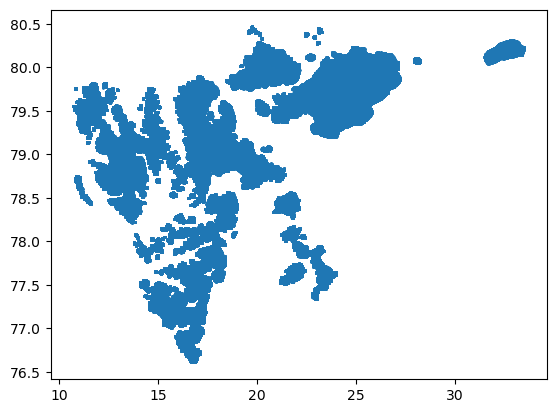

In [38]:
plt.scatter(df_glacier_grids_allglaciers.POINT_LON, df_glacier_grids_allglaciers.POINT_LAT, s=1)

In [ ]:

glacier_groups = df_glacier_grids_allglaciers.groupby('RGI_ID')
spitsbergen_allgrids = pd.DataFrame()

for i, rgi in glacier_groups:
    if i not in ['RGI60-07.00045','RGI60-07.01545','RGI60-07.01557']: # these glaciers are not on the islands we want to have in our dataset, but are not excluded by the coordinates, so we use this getaround
        if rgi.POINT_LON.max()<19 or rgi.POINT_LAT.max()<79.3:
            rgi['RGI_ID']=i
            spitsbergen_allgrids=pd.concat([spitsbergen_allgrids, rgi])
        


In [ ]:
# saving all the new datasets
spitsbergen_measurements.to_csv('../data/spitsbergen_measurements_aggregated_nosurges_dhdt2014smoothed_complete.csv') # save the measurements
#df_spitsbergen_grids.to_csv('../data/spitsbergen_griddeddata_nosurges_dhdt2014smoothed.csv') # gridded data of the glaciers with measurements
spitsbergen_allgrids.to_csv('../data/spitsbergen_allunmapped_griddeddata_nosurges_dhdt2014smoothed_complete.csv') # gridded data of all the glaciers in the region

Plotting the new datasets (including a plot about the LOGO test glaciers)

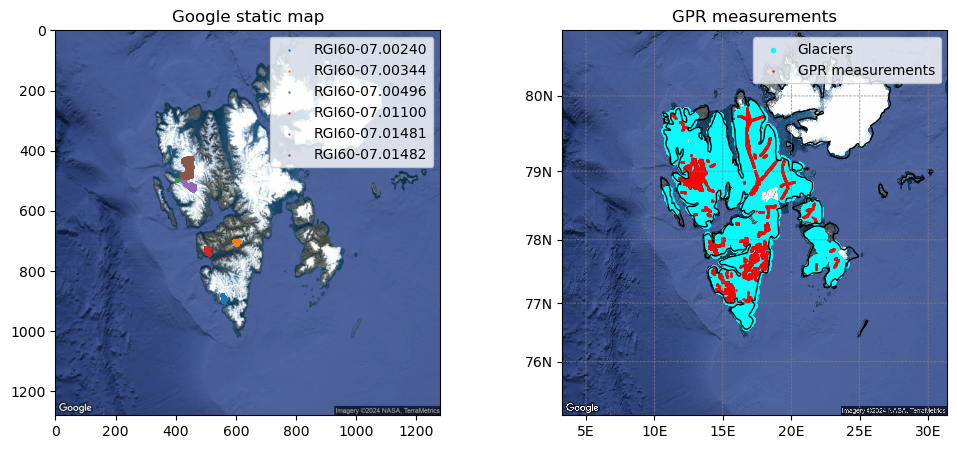

In [45]:
plt.style.use('default')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))#
crs_lonlat = pyproj.crs.CRS.from_epsg(4326)

g = GoogleVisibleMap(x=[spitsbergen_allgrids.POINT_LON.min(),spitsbergen_allgrids.POINT_LON.max()], y=[spitsbergen_allgrids.POINT_LAT.min(), spitsbergen_allgrids.POINT_LAT.max()],
                     scale=2,  # scale is for more details
                     maptype='satellite', crs=crs_lonlat)
ggl_img = g.get_vardata()

sm = Map(g.grid, factor=1, countries=True)
sm.set_rgb(ggl_img)  # add the background rgb image
glaciergroups = df_spitsbergen_grids.groupby('RGI_ID')
for c, rgi in enumerate(['RGI60-07.00240','RGI60-07.00344','RGI60-07.00496','RGI60-07.00496','RGI60-07.01100','RGI60-07.01481','RGI60-07.01482']):
    g=glaciergroups.get_group(rgi)
    x, y = sm.grid.transform(g.POINT_LON.values, g.POINT_LAT.values,crs=crs_lonlat)
    ax1.scatter(x, y, marker='.',  label=rgi,s=2,)
ax1.legend()

ax1.imshow(ggl_img)
ax1.set_title('LOGO Test Glaciers')

sm.set_lonlat_contours(yinterval=1, xinterval=5, linewidths=0.5, linestyles='--', colors='gray')

sm.visualize(ax=ax2)  # plot it
ax2.set_title('GPR measurements')
x, y = sm.grid.transform(spitsbergen_allgrids.POINT_LON.values, spitsbergen_allgrids.POINT_LAT.values,crs=crs_lonlat)
ax2.scatter(x, y, marker='.', c='cyan', label='Glaciers')#, c=itslive.dataset.labeled_dataset.consensus_ice_thickness, s=10,  linewidths=1)

x, y = sm.grid.transform(spitsbergen_measurements.POINT_LON.values, spitsbergen_measurements.POINT_LAT.values,crs=crs_lonlat)
ax2.scatter(x, y,marker='.', c='r', s=2, label='IPR measurements & all glaciers\'s grids')

ax2.legend(markerscale=10)
plt.legend()

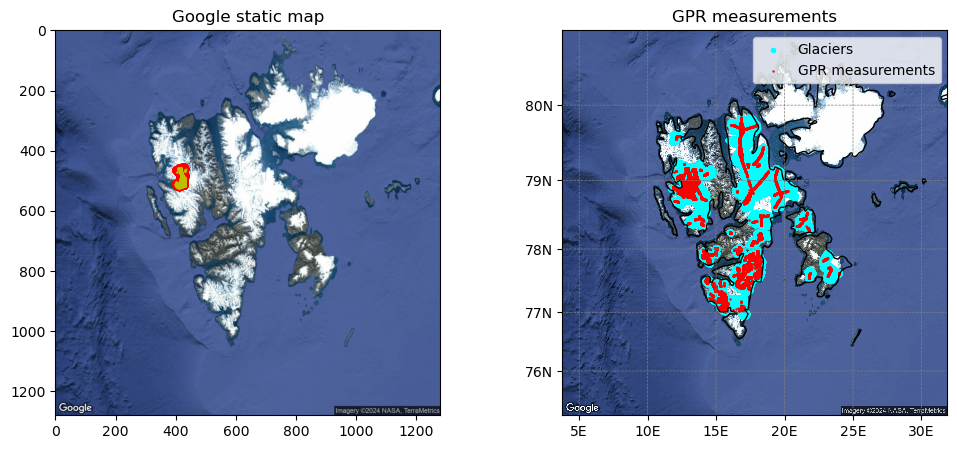

In [201]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))#
crs_lonlat = pyproj.crs.CRS.from_epsg(4326)

g = GoogleVisibleMap(x=[df_spitsbergen_grids.POINT_LON.min(),df_spitsbergen_grids.POINT_LON.max()], y=[df_spitsbergen_grids.POINT_LAT.min(), df_spitsbergen_grids.POINT_LAT.max()],
                     scale=2,  # scale is for more details
                     maptype='satellite', crs=crs_lonlat)
ggl_img = g.get_vardata()

sm = Map(g.grid, factor=1, countries=True)
sm.set_rgb(ggl_img)  # add the background rgb image

x, y = sm.grid.transform(df_singleglacier_grid.POINT_LON.values, df_singleglacier_grid.POINT_LAT.values,crs=crs_lonlat)
ax1.scatter(x, y, marker='.', c='r')
x, y = sm.grid.transform(df_singleglacier_measurement.POINT_LON.values, df_singleglacier_measurement.POINT_LAT.values,crs=crs_lonlat)
ax1.scatter(x, y, marker='.', c='y', s=1)

ax1.imshow(ggl_img)
ax1.set_title('RGI 01482')


sm.set_lonlat_contours(yinterval=1, xinterval=5, linewidths=0.5, linestyles='--', colors='gray')

sm.visualize(ax=ax2)  # plot it
ax2.set_title('GPR measurements')
x, y = sm.grid.transform(df_spitsbergen_grids.POINT_LON.values, df_spitsbergen_grids.POINT_LAT.values,crs=crs_lonlat)
ax2.scatter(x, y, marker='.', c='cyan', label='Glaciers')#, c=itslive.dataset.labeled_dataset.consensus_ice_thickness, s=10,  linewidths=1)

x, y = sm.grid.transform(spitsbergen_measurements.POINT_LON.values, spitsbergen_measurements.POINT_LAT.values,crs=crs_lonlat)
ax2.scatter(x, y,marker='.', c='r', s=2, label='IPR measurements & measured glaciers\'s grids')
glaciergroups = df_spitsbergen_grids.groupby('RGI_ID')

ax2.legend(markerscale=10)
plt.legend()